# 3.2.2 Deep analysis of DB_TOTAL_TIME and CPU_TIME

This notebook answers the following questions:

- [X] What is the difference in values between the DB_TOTAL_TIME and CPU_TIME fields?
- [X] Is there a relationship between the DB_TOTAL_TIME and DB_BLOCKS fields?
- [X] Is there a relationship between the CPU_TIME and ROW_COUNT fields?

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

### Aligning data visualizations

The following code is used to center and align the visualizations laid out below.

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""") 

### Loadind Data

In [3]:
source_path_reports = "./datasets/active_reports.csv"

reports = pd.read_csv(source_path_reports)
reports['DB_TOTAL_TIME'] = reports.apply(lambda row: (row['DB_TOTAL_TIME']/1000000), axis=1)

In [4]:
source_path_pg_view = "data/Salesforce/ELF/LightningPageView/2022-06-20_LightningPageView.csv"

page_view = pd.read_csv(source_path_pg_view)

## 1. What is the difference in values between the DB_TOTAL_TIME and CPU_TIME fields?

Before we start with data manipulation, it is necessary to clarify which are the fields of interest in this analysis:
1. **DB_TOTAL_TIME**: The time in nanoseconds for a database round trip. Includes time spent in the JDBC driver, network to the database, and DB_CPU_TIME. Compare this field to CPU_TIME to determine whether performance issues are occurring in the database layer or in your own code;
2. **DB_CPU_TIME**: The CPU time in milliseconds to complete the request. Indicates the amount of activity taking place in the database layer during the request;
3. **CPU_TIME**: The CPU time in milliseconds used to complete the request. This field indicates the amount of activity taking place in the app server layer;
4. **DB_BLOCKS**: Indicates how much activity is occurring in the database. A high value for this field suggests that adding indexes or filters on your queries would benefit performance;
5. **ROW_COUNT**: The number of rows that were processed in the Report event.

All definitions detailed above can be found in this [reference](https://developer.salesforce.com/docs/atlas.en-us.238.0.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_report.htm). In this analysis, it was decided to define a new metric (**TIME_VARIATION**) to evaluate the average time of the difference between the **DB_TOTAL_TIME** and **CPU_TIME** fields.

### 1.1 Analysis of data skewness and spread

To start exploring the data, the skewness and spread of the fields under analysis are verified via box plots and the [five-number summary](https://en.wikipedia.org/wiki/Five-number_summary). So, the following are boxplots for DB_TOTAL_TIME, CPU_TIME, TIME_VARIATION.

In [5]:
reports['TIME_VARIATION'] = reports.apply(lambda row: (row['DB_TOTAL_TIME'] - row['CPU_TIME']), axis=1)

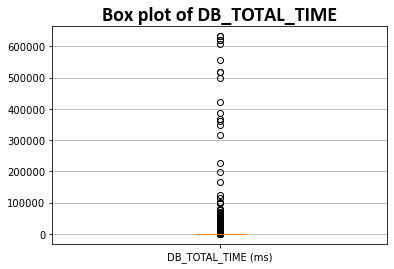

In [6]:
plt.grid(True, axis='y')

plt.boxplot(reports['DB_TOTAL_TIME'], labels = ['DB_TOTAL_TIME (ms)'])
plt.title('Box plot of DB_TOTAL_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

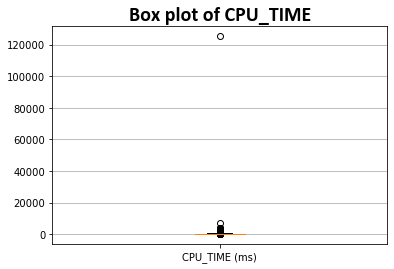

In [7]:
plt.grid(True, axis='y')

plt.boxplot(reports['CPU_TIME'], labels = ['CPU_TIME (ms)'])
plt.title('Box plot of CPU_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

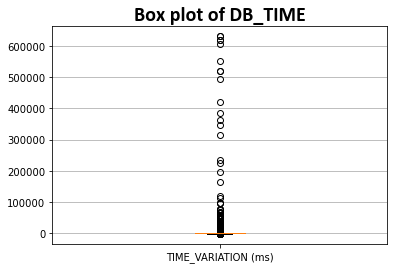

In [8]:
plt.grid(True, axis='y')

plt.boxplot(reports['TIME_VARIATION'], labels = ['TIME_VARIATION (ms)'])
plt.title('Box plot of DB_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

As we can see from the boxplots plotted above, there is a large skewness in the fields under analysis for this sample, as a large number of outliers are present.

### 1.2 Analysis of TIME_VARIATION values

The following code quantifies the difference between the DB_TOTAL_TIME and CPU_TIME fields (i.e. the difference between the times spent on the server and application layers).

In [9]:
values_greater_zero = reports['TIME_VARIATION'].apply(lambda value: value > 0)
v_counts = values_greater_zero.value_counts()

print(f"Total number of values: {v_counts[1] + v_counts[0]}")
print(f"Values where DB_TOTAL_TIME > CPU_TIME: {v_counts[1]}")

Total number of values: 7101
Values where DB_TOTAL_TIME > CPU_TIME: 1364


- For clarity, below is a pie chart detailing the values. Such visualization shows that, for this sample, in most cases the CPU_TIME field (time spent in the application) is greater than the DB_TOTAL_TIME field (time spent on the server).

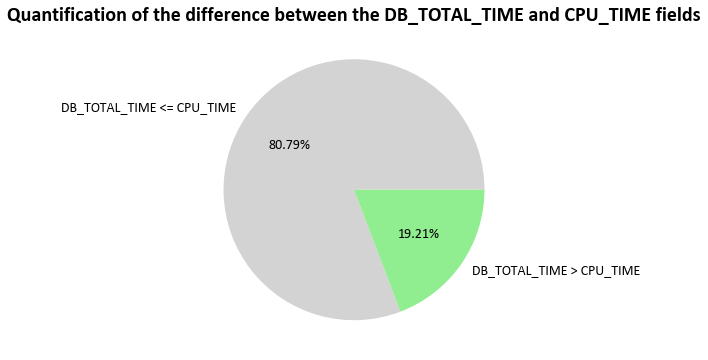

In [10]:
plt.figure(figsize=(6,6))
plt.pie(v_counts, autopct='%1.2f%%', radius=1, 
        labels = ['DB_TOTAL_TIME <= CPU_TIME', 'DB_TOTAL_TIME > CPU_TIME'], 
        textprops = {'size': 14, 'font': 'Calibri'}, colors=['lightgrey' ,'lightgreen'])

plt.title('Quantification of the difference between the DB_TOTAL_TIME and CPU_TIME fields', 
          fontsize=20, fontweight="bold", fontname="Calibri");
plt.show() 

### 1.2.1 Analysis of TIME_VARIATION in relation to the average value

The following analysis concerns the evaluation of above-average TIME_VARIATION values for the active_reports file.

In [11]:
dbt_mean = reports['TIME_VARIATION'].mean()
dbt_median = reports['TIME_VARIATION'].median()

print(f"Mean = {dbt_mean:.2f} miliseconds")
print(f"Median = {dbt_median:.2f} miliseconds")

Mean = 1917.69 miliseconds
Median = -224.98 miliseconds


- In view of the above results, it is noted that the skewness of the data causes a large difference between the mean and median measures.

In [12]:
above_mean = reports['TIME_VARIATION'].apply(lambda value: value > dbt_mean)
above_mean.value_counts()

False    6480
True      621
Name: TIME_VARIATION, dtype: int64

- The following pie chart demonstrates that the vast majority of TIME_VARIATION values are below the average (91.25%). This fact confirms that the time spent on the server is lower than the time spent on the application.

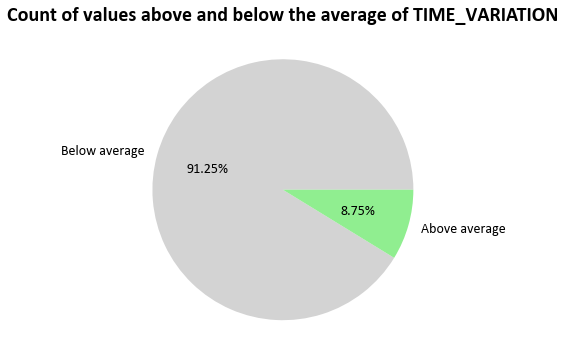

In [13]:
plt.figure(figsize=(6,6))
plt.pie(above_mean.value_counts(), autopct='%1.2f%%', radius=1.0, labels = ['Below average','Above average'],  
        textprops = {'size': 14, 'font': 'Calibri'}, colors=['lightgrey' ,'lightgreen'])

plt.title('Count of values above and below the average of TIME_VARIATION', fontsize=20, fontweight="bold", fontname="Calibri");
plt.show()

### 1.4 Analysis of TIME_VARIATION by REPORT_ID_DERIVED

The following analysis concerns the evaluation of TIME_VARIATION values by REPORT_ID_DERIVED against the data generated by merging the active_reports and LightningPageView tables.

In [14]:
page_view = page_view.drop(columns=['EVENT_TYPE',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'CLIENT_IP']) 


In [15]:
run_report_api_resource = "/lightning/r/"

def get_report_info_from_endpoint(page_url):
    if page_url.startswith(run_report_api_resource):
        uri = page_url.split(run_report_api_resource)
        if len(uri) >= 2:
            report_type, report_id_derived = uri[1].split("/")[:2]
            return report_type, report_id_derived

In [16]:
page_view.dropna(subset=['PAGE_URL'], inplace=True)

page_view['REPORT_INFO_DERIVED'] = page_view.PAGE_URL.apply(get_report_info_from_endpoint)
page_view.dropna(subset=['REPORT_INFO_DERIVED'], inplace=True)

page_view['REPORT_TYPE_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[0]
page_view['REPORT_ID_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[1]

page_view = page_view.drop(columns='REPORT_INFO_DERIVED')

In [17]:
merged_data = pd.merge(left=reports, right=page_view, on='REPORT_ID_DERIVED')

In [18]:
dbt_mean = merged_data['TIME_VARIATION'].mean()
dbt_median = merged_data['TIME_VARIATION'].median()

print(f"Mean = {dbt_mean:.2f} miliseconds")
print(f"Median = {dbt_median:.2f} miliseconds")


Mean = -129.40 miliseconds
Median = -233.84 miliseconds


- After merging the data, it is noticed that the measures of central tendency become more similar due to the reduction of the mean value.

In [19]:
merged_data['TIME_VARIATION'] = merged_data.apply(lambda row: (row['TIME_VARIATION']/1000)/60, axis=1)

In [20]:
grouping = merged_data.groupby("REPORT_ID_DERIVED")['TIME_VARIATION'].sum()
grouping = grouping.sort_values(axis=0)

- The table below informs that in 4 of the 6 values of REPORT_ID_DERIVED present in the sample, the CPU_TIME field is greater than DB_TOTAL_TIME. It is also noted that the id **00O0b000004kTazEAE** has by far the highest CPU_TIME values.

In [21]:
df = pd.DataFrame ({
        'REPORT_ID_DERIVED': grouping.keys(),
        'TIME_VARIATION (seconds)': grouping.values
})
df

,REPORT_ID_DERIVED,TIME_VARIATION (seconds)
0,00O0b000004kTazEAE,-1200.607950
1,00O2R000003JSoUUAW,-3.135406
2,00O2R000003zZykUAE,-0.030897
3,00O6P000000VFRvUAO,-0.028663
4,00O6P0000016vmQUAQ,0.366775
5,00O2R000003JUDGUA4,2.478720


## 2. Is there a relationship between the DB_TOTAL_TIME and DB_BLOCKS fields?

Next, an analysis of the DB_BLOCKS field is performed to quantify how much activity is occurring in the database by REPORT_ID_DERIVED. For this purpose, the tables below were generated, ordered from the highest to the lowest values.

In [22]:
grouping = merged_data.groupby("REPORT_ID_DERIVED")['DB_BLOCKS'].sum()
grouping = grouping.sort_values(axis=0, ascending=False)

In [23]:
df = pd.DataFrame ({
        'REPORT_ID_DERIVED': grouping.keys(),
        'DB_BLOCKS': grouping.values
})
df

,REPORT_ID_DERIVED,DB_BLOCKS
0,00O0b000004kTazEAE,6.272316e+09
1,00O2R000003JSoUUAW,1.003624e+07
2,00O2R000003JUDGUA4,2.759012e+06
3,00O6P0000016vmQUAQ,6.416790e+05
4,00O6P000000VFRvUAO,2.461840e+05
5,00O2R000003zZykUAE,1.496700e+04


In [24]:
grouping2 = merged_data.groupby("REPORT_ID_DERIVED")['DB_TOTAL_TIME'].sum()
grouping2 = grouping2.sort_values(axis=0, ascending=False)

In [25]:
df2 = pd.DataFrame ({
        'REPORT_ID_DERIVED': grouping2.keys(),
        'TOTAL_TIME (ms)': grouping2.values
})
df2

,REPORT_ID_DERIVED,TOTAL_TIME (ms)
0,00O0b000004kTazEAE,1.306755e+08
1,00O2R000003JUDGUA4,1.821672e+05
2,00O2R000003JSoUUAW,1.127716e+05
3,00O6P0000016vmQUAQ,2.565548e+04
4,00O6P000000VFRvUAO,3.732231e+03
5,00O2R000003zZykUAE,1.001162e+03


- The tables above indicate a clear relationship between DB_BLOCKS and DB_TOTAL_TIME (only the second and third rows are in swapped positions). This fact is in agreement with the results obtained from the correlation matrix generated in [this task](https://github.com/dell-splab/lightning-analysis/blob/main/3.2%20Is%20the%20bottleneck%20in%20the%20application%20level%20.ipynb) (which demonstrates a high correlation between the DB_BLOCKS and DB_CPU_TIME fields). Since DB_TOTAL_TIME is dependent on DB_CPU_TIME, it makes sense for the DB_BLOCKS field to influence DB_TOTAL_TIME.
- Note that, as with the CPU_TIME field, the id **00O0b000004kTazEAE** has by far the highest values of DB_TOTAL_TIME.

## 3. Is there a relationship between the CPU_TIME and ROW_COUNT fields?

Below is an analysis to assess whether there is a relationship between CPU_TIME and ROW_COUNT by REPORT_ID_DERIVED. For this, the tables below were generated, ordered from the highest to the lowest values.

In [26]:
grouping = merged_data.groupby("REPORT_ID_DERIVED")['CPU_TIME'].sum()
grouping = grouping.sort_values(axis=0 ,ascending=False)

In [27]:
df = pd.DataFrame ({
        'REPORT_ID_DERIVED': grouping.keys(),
        'CPU_TIME (ms)': grouping.values
})
df

,REPORT_ID_DERIVED,CPU_TIME (ms)
0,00O0b000004kTazEAE,202712004
1,00O2R000003JSoUUAW,300896
2,00O2R000003JUDGUA4,33444
3,00O6P000000VFRvUAO,5452
4,00O6P0000016vmQUAQ,3649
5,00O2R000003zZykUAE,2855


In [28]:
grouping2 = merged_data.groupby("REPORT_ID_DERIVED")['ROW_COUNT'].sum()
grouping2 = grouping2.sort_values(axis=0 ,ascending=False)

In [29]:
df2 = pd.DataFrame ({
        'REPORT_ID_DERIVED': grouping2.keys(),
        'ROW_COUNT': grouping2.values
})
df2

,REPORT_ID_DERIVED,ROW_COUNT
0,00O0b000004kTazEAE,8228187.0
1,00O2R000003JSoUUAW,84502.0
2,00O2R000003JUDGUA4,37876.0
3,00O6P000000VFRvUAO,4222.0
4,00O2R000003zZykUAE,56.0
5,00O6P0000016vmQUAQ,13.0


From the tables above, there is strong evidence of a relationship between the CPU_TIME and ROW_COUNT fields (only rows 4 and 5 of the tables are swapped with respect to each other). This fact confirms once again the results obtained in [this task](https://github.com/dell-splab/lightning-analysis/blob/main/3.2%20Is%20the%20bottleneck%20in%20the%20application%20level%20.ipynb).